# 3D DEEP LEARNING - HARDCORE VERSION 💀

Welcome to the 3D Deep Learning Workshop!

In this workshop, you'll learn to:
* Process a 3D Point Cloud Dataset
* Visualize the Dataset in 3D
* Build a 3D Deep Learning Model
* Test on new data

The code has been adapted from Intel's version for education purpose: https://github.com/intel-isl/Open3D-PointNet


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jeremy26/3d-deep-learning/blob/main/3D%20Deep%20Learning/3D_DL_Starter_Hardcore.ipynb)

## Imports
We'll need a few things to get started:
* Open3D: A Point Cloud Library; we'll use it for Visualization - We use version 12
* PyTorch: A Deep Learning Library - We Use version 1.7
* All the other usual libraries (numpy, matplotlib, random, ...)

In [ ]:
# Do this if you don't have Open3D
# !pip install open3d==0.12.0 # Version 12
# !pip install progressbar

In [1]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)
# from open3d import JVisualizer # Useful for Jupyter Notebook Visualization
from open3d.web_visualizer import draw

# PyTorch Imports
import torch #Version 1.7.0 is the one used in the course
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
0.16.0
[Open3D INFO] Resetting default logger to print to terminal.
1.11.0


# Dataset

We are going to work with the ShapeNet Dataset.<p>
It's coming from Standford and will allow us to do both Classification and Segmentation.<p>
Here's an X-Wing from the DataSet:
![XWING](https://www.shapenet.org/shapenet/screenshots/models/3dw/d/d/9/e/c/e07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356-5.png)

## Download the Dataset

In [2]:
#Run this only if you don't already have the Dataset
# !wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
# !unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
# !rm shapenetcore_partanno_segmentation_benchmark_v0.zip

In [3]:
# Avoid an SSL Error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Preprocess the Dataset

In [4]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = 'shapenetcore_partanno_segmentation_benchmark_v0'

In [75]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    TODO: This part has already been coded for you and is functional.
    TODO: But there is still an assignment
    TODO: Understand it well enough so you can add a visualization of the segmentation image and return it.
    """
    def __init__(self, root, npoints=2500, classification=False, class_choice=None, train=True, image=False):
        '''
        Assign the parameters: number of points, root folder, category file, image, classification.
        '''
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.image = image
        self.classification = classification
        self.train = train
        '''
        Open the Category File and Map Folders to Categories
        '''
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        #print(self.cat)
        
        '''
        Select categories from the dataset. 
        ex: Call in parameters "class_choice=["Airplane"].
        '''
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        '''
        For every item in a specific category, assign the point, segmentation, and image.
        Basically, read the dataset and store the labels.
        '''
        self.meta = {}        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            # TODO: Modify below
            dir_seg_img = os.path.join(self.root, self.cat[item], 'seg_img')
            #print(dir_point, dir_seg)
            

            # get split based on whether we are training or testing (no validation?)
            # we should try to use the .json files to get the splits
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            #print(os.path.basename(fns))
            for fn in fns: # FOR EVERY POINT CLOUD FILE
                token = (os.path.splitext(os.path.basename(fn))[0])
                # TODO:Modify below
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), 
                                        os.path.join(dir_seg, token + '.seg'),
                                        os.path.join(dir_seg_img, token + '.png')))

        '''
        Create a Variable where you have (item, points, segmentation points, segmentation image)
        '''
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                # TODO: Modify below
                self.datapath.append((item, fn[0], fn[1], fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        #print(self.classes)
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                # TODO: Modify below
                l = len(np.unique(np.loadtxt(self.datapath[i][2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)

    def __getitem__(self, index):
        '''
        This will be used to pick a specific element from the dataset.
        self.datapath is the dataset.
        Each element is under format "class, points, segmentation labels, segmentation image"
        '''
        # Get one Element
        fn = self.datapath[index]
        #print(fn)
        
        # get its Class
        cls = self.classes[fn[0]]
        #print(cls)
        
        # Read the Point Cloud
        point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
        
        # Read the Segmentation Data
        seg = np.loadtxt(fn[2]).astype(np.int64)

        #print(point_set.shape, seg.shape)
        
        # TODO: Read the Segmentation Image
        # image = np.array(Image.open(fn[3]))
        image = Image.open(fn[3])
        # image = read_image(fn[3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        #resample
        point_set = point_set[choice, :]        
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        
        # add Gaussian noise to point set if training mode is active
        if self.train:
            # add N(0, 1/100) noise
            point_set += torch.randn(point_set.shape)/100

        # consider adding random rotations to the object 
        # construct a randomly parameterized 3x3 rotation matrix
        
        
        if self.classification:
            if self.image:
                return point_set, cls, image
            else:
                return point_set, cls

        else:
            if self.image:
                return point_set, seg, image
            else:
                return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [76]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

## Visualize the Dataset with Open3D

In [77]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[ 0.0111,  0.0973, -0.2322],
        [ 0.1066,  0.0954,  0.3008],
        [-0.1440,  0.0967,  0.1384],
        ...,
        [ 0.0541,  0.0919,  0.0400],
        [ 0.1529,  0.0933,  0.2125],
        [-0.0263, -0.0865, -0.0357]])
----------
Label on Part Segmentation
tensor([1, 1, 1,  ..., 1, 1, 2])
----------
Label on Classification
Table


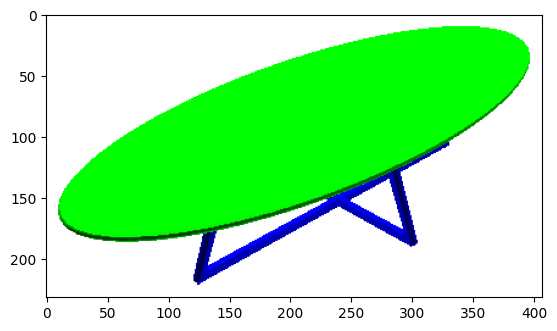

In [78]:
# Load the ShapeNet Dataset
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

#TODO: Get a Dataset for segmentation and with the image you got
d = PartDataset(DATA_FOLDER, npoints=2500, classification=False, class_choice=None, train=True, image=True)
print("Number of objects",len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(),seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')

# #TODO: Get a Dataset for Classification with the same index and without the image
d = PartDataset(DATA_FOLDER, npoints=2500, classification=True, class_choice=None, train=True, image=False)
ps2, class_ = d[idx]

print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[class_.item()])

plt.imshow(np.asarray(img))

In [79]:
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

# test_vis.add_geometry(test_cloud)
# test_vis.show()

draw(test_cloud)

WebVisualizer(window_uid='window_34')

# 3D Deep Learning Model: PointNet

## Build the Model: PointNet

**The model is PointNet.**<p>
![PointNet](https://d3i71xaburhd42.cloudfront.net/c3b6a072288e134f5ae6afe3eebc970ffb65cb68/3-Figure2-1.png)

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

### Build the T-Net

NOTE: Since we are using Batch Normalizations, we will need to pass a batch size of greater than 1 during training since Batch Norm expects multiple batch values in order to compute the Mean and Std across the batch. Make sure to set the model to inference/evalutation mode using ```model = model.eval()```, this way the model will not explicitly require multiple batch samples.


See https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274

In [80]:
# consider using a sequential for the T-net

class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, dim, num_points=2500):
        super(STN3d, self).__init__()

        # dimensions for transform matrix
        self.dim = dim 

        self.conv1 = nn.Conv1d(dim, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv3 = nn.Conv1d(128, 1024, kernel_size=1)

        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, dim**2)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.max_pool = nn.MaxPool1d(kernel_size=num_points)
        

    def forward(self, x):
        bs = x.shape[0]

        # pass through shared MLP layers (conv1d)
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))

        # max pool over num points
        x = self.max_pool(x).view(bs, -1)
        
        # pass through MLP
        x = self.bn4(F.relu(self.linear1(x)))
        x = self.bn5(F.relu(self.linear2(x)))
        x = self.linear3(x)

        # initialize identity matrix
        iden = torch.eye(self.dim, requires_grad=True).repeat(bs, 1, 1)
        if x.is_cuda:
            iden = iden.cuda()

        x = x.view(-1, self.dim, self.dim) + iden

        return x

sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d(dim=3)
out = trans(sim_data)
# print("Output Size must be [32, 3, 3]")
print('stn', out.size())


stn torch.Size([32, 3, 3])


In [9]:
trans = STN3d(dim=3).eval()
out = trans(sim_data[0, :, :].unsqueeze(0))

### Build the Feature T-Net + MLP

### Build the backbone of Point Net

When the term backbone is used in Deep Learning, people usually refer to different pre-trained Convolutional Nerual Networks (CNNs) that are used to extract features. In this case we are still using the backbone to extract features, but we are using a much more simple architecture than the typical CNNs. Here we are using a simple network that primarily consists of shared MLPs (1D convolutions) and some other add-ons such as Max Pooling and Batch Normalization. The secret sauce here is the Spatial Transformer Networks, these learn different representation of point clouds, allowing the PointNet to consume point clouds in any orientation. 

The important thing to note here, is that the Backbone portion extracts both global and local features of the point cloud. While only global features will be used for classification (similar to CNNs), a combination of Local and Global Features will be used for segmentation allowing the segmentation head to learn from a rich representation of features that simultaneously includes global location and local context (somewhat similar to U-net).


References: 
 - https://stackoverflow.com/questions/59868132/what-does-backbone-mean-in-a-neural-network
 - 

In [81]:
# Restructure this... (This is the point net before classifcation and segmentation heads)
class PointNetBackbone(nn.Module):
    """
    This is the main portion of Point Net before the classification and segmentation heads.
    The main function of this network is to obtain the local and global point features, 
    which can then be passed to each of the heads to perform either classification or
    segmentation. The forward pass through the backbone includes both T-nets and their 
    transformations, the shared MLPs, and the max pool layer to obtain the global features.
    """
    def __init__(self, num_points=2500, local_feat=True):
        super(PointNetBackbone, self).__init__()

        # if true concat local and global features
        self.num_points = num_points
        self.local_feat = local_feat

        # Spatial Transformer Networks (T-nets)
        self.stn1 = STN3d(dim=3, num_points=num_points)
        self.stn2 = STN3d(dim=64, num_points=num_points)

        # shared MLP 1
        self.conv1 = nn.Conv1d(3, 64, kernel_size=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=1)

        # shared MLP 2
        self.conv3 = nn.Conv1d(64, 64, kernel_size=1)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv5 = nn.Conv1d(128, 1024, kernel_size=1)
        
        # batch norms for both shared MLPs
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)

        # max pool to get the global features
        self.max_pool = nn.MaxPool1d(kernel_size=num_points)

    
    def forward(self, x):

        # get batch size
        bs = x.shape[0]
        
        # pass through first Tnet to get transform matrix
        trans1 = self.stn1(x)

        # perform first transformation across each point in the batch
        x = torch.bmm(x.transpose(2, 1), trans1).transpose(2, 1)

        # pass through first shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        
        # get feature transform
        trans2 = self.stn2(x)

        # perform second transformation across each (64 dim) feature in the batch
        x = torch.bmm(x.transpose(2, 1), trans2).transpose(2, 1)

        # store local point features for segmentation head
        local_features = x.clone()

        # pass through second MLP
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)))

        # get global feature vector
        global_features = self.max_pool(x).view(bs, -1)

        if self.local_feat:
            features = torch.cat((local_features, 
                                  global_features.unsqueeze(-1).repeat(1, 1, 2500)), 
                                  dim=1)

            return features, trans2

        else:
            return global_features, trans2
            


In [143]:
pointfeat = PointNetBackbone(local_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1088, 2500])


In [145]:
# test on single batch
pointfeat = PointNetBackbone(local_feat=True).eval()
out, _ = pointfeat(sim_data[0, :, :].unsqueeze(0))
out.shape

torch.Size([1, 1088, 2500])

### Build the Classification Head

In [82]:
class PointNetClassHead(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points=2500, k=2):
        super(PointNetClassHead, self).__init__()

        # get the backbone (only need global features for classification)
        self.backbone = PointNetBackbone(num_points=num_points, local_feat=False)

        # MLP for classification
        self.linear1 = nn.Linear(1024, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, k)

        # batchnorm for the first 2 linear layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)

        # The paper states that batch norm was only added to the layer 
        # before the classication layer, but another version adds dropout  
        # to the first 2 layers
        self.dropout = nn.Dropout(p=0.3)
        

    def forward(self, x):
        # get global features
        x, trans1 = self.backbone(x) 

        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        x = self.dropout(x)
        x = self.linear3(x)

        # return logits
        return x, trans1


        

In [149]:
pointfeat = PointNetBackbone(local_feat=False)
out, _ = pointfeat(sim_data)
print('global features', out.size())

pointfeat = PointNetBackbone(local_feat=True)
out, _ = pointfeat(sim_data)
print('combined features', out.size())

classifier = PointNetClassHead(k=5)
out, _ = classifier(sim_data)
print('class', out.size())

global features torch.Size([32, 1024])
combined features torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


In [151]:
classifier = PointNetClassHead(k=5).eval()
out, _ = classifier(sim_data[0, :, :].unsqueeze(0))
print(out.shape)

torch.Size([1, 5])


### Build the Segmentation Head

NOTE: The authors of the paper use a slightly different network architecture to perform part segmentation. They concatenate point features from different portions of the network as well as a one-hot vector of classes to indicate the current class and add some skip connections. This network head will be the one contained in the original paper. Per the paper, the arhcitecure of the Segmentation head is used for semantic segmentation.

In [83]:
class PointNetSegHead(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points=2500, m=2):
        super(PointNetSegHead, self).__init__()

        self.num_points = num_points
        self.m = m

        # get the backbone 
        self.backbone = PointNetBackbone(num_points=num_points, local_feat=True)

        # shared MLP
        self.conv1 = nn.Conv1d(1088, 512, kernel_size=1)
        self.conv2 = nn.Conv1d(512, 256, kernel_size=1)
        self.conv3 = nn.Conv1d(256, 128, kernel_size=1)
        self.conv4 = nn.Conv1d(128, m, kernel_size=1)

        # batch norms for shared MLP
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)


    def forward(self, x):
        
        # get combined features
        x, trans1 = self.backbone(x) 

        # pass through shared MLP
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.conv4(x)

        x = x.transpose(2, 1)
        
        return x, trans1

In [153]:
seg = PointNetSegHead(m=3)
# print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

seg torch.Size([32, 2500, 3])


In [157]:
# test on batch with single sample
seg = PointNetSegHead(m=3).eval()
out, _ = seg(sim_data[0, :, :].unsqueeze(0))
print('seg', out.size())

seg torch.Size([1, 2500, 3])


## Train the Model for classification and segmentation

In [84]:
# TODO: Define Hyperparameters
batchSize = 32
num_points = 2500
nepoch = 10
outf="cls" #Out folder, saving each epoch

### NOTE: ADD Mathews Correlation Coefficent as an additional metric

In [85]:
# DATASET & DATA LOADER

from torch.utils.data import DataLoader
import time

# Train Dataset & DataLoader

# segmentation
# dataset = PartDataset(DATA_FOLDER, npoints=2500, classification=False, class_choice=None, train=True, image=True)

# classification
dataset = PartDataset(DATA_FOLDER, npoints=num_points, classification=True, class_choice=None, train=True, image=False)
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=0)

# Test Dataset & DataLoader
test_dataset = PartDataset(DATA_FOLDER, npoints=num_points, classification=True, class_choice=None, train=False, image=False)
testdataloader = DataLoader(test_dataset, batch_size=batchSize, num_workers=0)

blue = lambda x:'\033[94m' + x + '\033[0m'

# get model
num_classes = len(classes_dict.items())
classifier = PointNetClassHead(num_points=num_points, k=num_classes)

optimizer = optim.Adam(classifier.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)/batchSize # What is the number of batch?

# lists to store metrics
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

# TRAIN ON EPOCHS
for epoch in range(nepoch):

    # place model in training mode
    classifier = classifier.train()
    _train_loss = []
    _train_accuracy = []
    for i, (points, targets) in enumerate(dataloader, 0):
        """
        Get Points & Classification Label
        """

        points = points.transpose(2, 1)
        targets = targets.squeeze()
        
        if torch.cuda.is_available():
            points, targets = points.cuda(), targets.cuda()
        
        # zero gradients
        optimizer.zero_grad()
        
        # get predicted class logits
        preds, _ = classifier(points)
        
        # get loss and perform backprop
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
        # get class predictions
        pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
        correct = pred_choice.eq(targets.data).cpu().sum()
        accuracy = correct.item()/float(batchSize)

        # update epoch loss and accuracy
        _train_loss.append(loss.item())
        _train_accuracy.append(accuracy)

        if i % 100 == 0:
            print('\t [%d: %d/%d] train loss: %f accuracy: %f' \
                  % (epoch, i, num_batch, loss.item(), accuracy))
        
        # if i % 10 == 0:
        #     j, data = next(enumerate(testdataloader, 0))
        #     points, target = data
        #     points, target = Variable(points), Variable(target[:,0])
        #     points = points.transpose(2, 1)
        #     if torch.cuda.is_available():
        #         points, target = points.cuda(), target.cuda()
        #     classifier = classifier.eval()
        #     pred, _ = classifier(points)
        #     loss = F.nll_loss(pred, target)
        #     pred_choice = pred.data.max(1)[1]
        #     correct = pred_choice.eq(target.data).cpu().sum()
        #     print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    train_loss.append(np.mean(_train_loss))
    train_accuracy.append(np.mean(_train_accuracy))

    print(f'Epoch: {epoch} - Train Loss: {train_loss[-1]} - Train Accuracy: {train_accuracy[-1]}')

    # pause to cool down
    time.sleep(5)

    # get test results after each epoch
    with torch.no_grad():

        # place model in evaluation mode
        classifier = classifier.eval()

        _test_loss = []
        _test_accuracy = []
        for i, (points, targets) in enumerate(testdataloader, 0):

            points = points.transpose(2, 1)
            targets = targets.squeeze()
            
            if torch.cuda.is_available():
                points, targets = points.cuda(), targets.cuda()

            preds, _ = classifier(points)
            loss = criterion(preds, targets)

            pred_choice = torch.softmax(preds, dim=1).argmax(dim=1) 
            correct = pred_choice.eq(targets.data).cpu().sum()
            accuracy = correct.item()/float(batchSize)

            # update epoch loss and accuracy
            _test_loss.append(loss.item())
            _test_accuracy.append(accuracy)

            if i % 100 == 0:
                print('\t [%d: %d/%d] %s loss: %f accuracy: %f' \
                      % (epoch, i, num_batch, blue('test'), loss.item(), accuracy))
        
        test_loss.append(np.mean(_test_loss))
        test_accuracy.append(np.mean(_test_accuracy))
        print(f'Epoch: {epoch} - Test Loss: {test_loss[-1]} - Test Accuracy: {test_accuracy[-1]}')

        # pause to cool down
        time.sleep(5)

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (outf, epoch))

	 [0: 0/499] train loss: 2.898310 accuracy: 0.031250
	 [0: 100/499] train loss: 0.682770 accuracy: 0.781250
	 [0: 200/499] train loss: 0.511253 accuracy: 0.875000
	 [0: 300/499] train loss: 0.239937 accuracy: 0.937500
	 [0: 400/499] train loss: 0.609390 accuracy: 0.781250
Epoch: 0 - Train Loss: 0.7154492557346821 - Train Accuracy: 0.7835
	 [0: 0/499] test loss: 0.001649 accuracy: 1.000000
Epoch: 0 - Test Loss: 0.5403343872894766 - Test Accuracy: 0.8381696428571429
	 [1: 0/499] train loss: 0.280528 accuracy: 0.906250
	 [1: 100/499] train loss: 0.489757 accuracy: 0.875000
	 [1: 200/499] train loss: 0.185255 accuracy: 0.937500
	 [1: 300/499] train loss: 0.433801 accuracy: 0.875000
	 [1: 400/499] train loss: 0.464709 accuracy: 0.906250
Epoch: 1 - Train Loss: 0.3512492551729083 - Train Accuracy: 0.8965625
	 [1: 0/499] test loss: 0.070978 accuracy: 0.968750
Epoch: 1 - Test Loss: 114602.09383597792 - Test Accuracy: 0.9313616071428571
	 [2: 0/499] train loss: 0.417503 accuracy: 0.875000
	 [2: 

In [121]:
MODEL_PATH = 'cls/cls_model_7.pth'
NUM_POINTS = 10000
NUM_CLASSES = len(classes_dict.items())

classifier = PointNetClassHead(num_points=NUM_POINTS, k=NUM_CLASSES) # Create the classification network from pre-trained model

if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
    
classifier.eval()

PointNetClassHead(
  (backbone): PointNetBackbone(
    (stn1): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (linear1): Linear(in_features=1024, out_features=512, bias=True)
      (linear2): Linear(in_features=512, out_features=256, bias=True)
      (linear3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (max_pool): MaxPool1d(kernel_size=10000, stride=10000, padd

# Visualize the output

[Sample 865 / 1785]


WebVisualizer(window_uid='window_54')

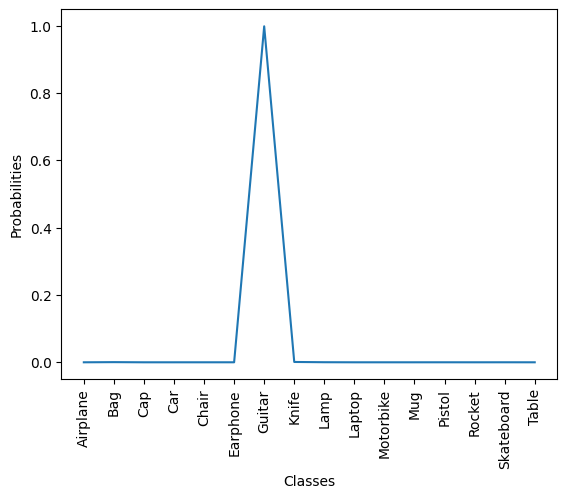

Your object is a [Guitar] with probability 0.998.


NameError: name 'STOP' is not defined

In [122]:
# Three.js based visualizer
# visualizer = JVisualizer()

#Get a dataset for testing
test_dataset_seg = PartDataset(root=DATA_FOLDER, train=False, classification=False, npoints=NUM_POINTS)

# Basic inference and visualization loop
MAX_SAMPLES = 15

for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    # visualizer.clear()
    # clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))


    # perform inference in GPU
    # points = Variable(point_set.unsqueeze(0))
    points = point_set.unsqueeze(0)
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()

    preds, _ = classifier(points)

    # softmax over predicted logits
    preds = torch.softmax(preds, dim=1) # .argmax(dim=1) 

    # move data back to cpu for visualization
    preds = preds.data.cpu().numpy().squeeze()
    # preds = np.exp(preds)
    pred_class = np.argmax(preds)

    # let's visualize the input sample
    # visualizer.add_geometry(cloud)
    # visualizer.show()

    draw(cloud)
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), preds)
    plt.show()

    print('Your object is a [{}] with probability {:0.3}.'.format(list(classes_dict.keys())[pred_class], preds[pred_class]))
    print(STOP)

    # input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
    #       .format(list(classes_dict.keys())[pred_class], preds[pred_class]))

### Interesting practical notes

We trained the point net with a sparse amount of points (2500) when we test the Point Net with the same sparse number of points, we get mediocre results. However, when we increase the number of point to say 10000, the results are much better. We are sending richer information to the point net, and the Point Net is able to adapt and seemingly make better use of the increased density of the Point Cloud.

When using unaugmented training data, the Point Net was very prone to overfitting. When we added Gaussian Noise to each (x,y,z) Point Cloud location in the training data the Point Net had significant improvements to the out of sample accuracy.

### Future Additions
- Use T-SNE to visualize the learned local and global features
- Add Matthews Correlation Coefficent to the evaluation metrics
- Check which classes have the best performance
- Modify the network to output the feature transformation matrix. This matrix is used in a regularization term in the softmax which should help with the optimization.

Get feature representation
See: https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/5

In [126]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        # print(len(output))
        activation[name] = output[0].detach()
    return hook


classifier.backbone.register_forward_hook(get_activation('backbone'))
preds, _ = classifier(points)

In [ ]:
classifier.backbone.

In [131]:
activation['backbone'].cpu().numpy()

array([[4.206028 , 3.9895632, 7.4927025, ..., 1.8886206, 2.0461302,
        5.428504 ]], dtype=float32)

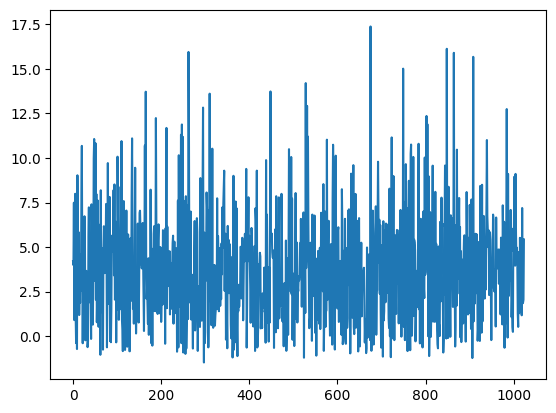

In [133]:
plt.plot(activation['backbone'].squeeze().cpu().numpy())

In [138]:
activation['backbone'].view(4, -1)

tensor([[ 4.2060,  3.9896,  7.4927,  ...,  4.7532,  6.9681, -0.9929],
        [ 7.8567, -0.6947,  0.8521,  ...,  0.7680,  2.7972,  2.5237],
        [ 3.3705,  3.1288,  3.3620,  ..., -0.7875, 10.2352, 10.7578],
        [ 0.5538,  0.0300,  1.6776,  ...,  1.8886,  2.0461,  5.4285]],
       device='cuda:0')